<a href="https://colab.research.google.com/github/nunununudayo/ms/blob/main/FootstepClassification_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import and Install Dependencies

## 1.1 Install Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install tensorflow tensorflow-gpu  matplotlib
!pip install tensorflow-io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1.2 Load Dependencies

In [ ]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

# 2. Build Data Loading Function

## 2.2 Build Dataloading Function

In [ ]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

# 3. Create Tensorflow Dataset

## 3.1 Define Paths to Positive and Negative Data

In [ ]:
def return_slices(FILEPATH):
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=11200, sequence_stride=11200, batch_size=1)
    return audio_slices

In [ ]:
#森田

person = 40 # AFPID-II_P2-Rawの場合

SS = [[]] * person

for i in range(person + 1):
  if i < 10:
    # AFPID-II_P2-Rawの場合
    SS[i-1] = os.path.join('/content/drive/MyDrive/audio_processing/intern/AFPID-II/AFPID-II_P2-Raw', 's0' + str(i))
  else:
    # AFPID-II_P2-Rawの場合
    SS[i-1] = os.path.join('/content/drive/MyDrive/audio_processing/intern/AFPID-II/AFPID-II_P2-Raw', 's' + str(i))


/content/drive/MyDrive/audio_processing/intern/AFPID-II/AFPID-II_P2-Raw/s02


## 3.2 Create Tensorflow Datasets

In [ ]:
#森田2
import os

ss = [[]] * person

for n in range(person):

  for i in os.listdir(SS[n]):
    # CALCULATE NUM
    #print(SS[n] + '/' + i)
    wav = load_wav_16k_mono(SS[n] + '/' + i)
    wav = wav[:int(len(wav) * 0.7)]

    # !!!!!!!!!!!!!!!!!!!!!!!!!!短縮版！！！！！！！！！！！！！！
    NUM = int(len(wav) / (0.75 * 16000)/10)
    #print(NUM)

    for j in range(NUM):
      ss[n].append(os.path.join(SS[n],i+str(j)))
      
  #print(ss[n])
  ss[n] = tf.data.Dataset.from_tensor_slices(ss[n])


## 3.3 Add labels and Combine Positive and Negative Samples

In [ ]:
#森田2
# data = tf.data.Dataset()
sis = []
for i in range(person):

  indices = i
  depth = person    

  sis.append( tf.data.Dataset.zip((ss[i], tf.data.Dataset.from_tensor_slices(([tf.one_hot(indices, depth)]*len(ss[i]))))) )

for i in range(len(sis)-1):
  sis[0] = sis[0].concatenate(sis[i+1])
data = sis[0]

print(len(data))

print(data.as_numpy_iterator().next())

65827
(b'/content/drive/MyDrive/audio_processing/intern/AFPID-II/AFPID-II_P2-Raw/s01/s01_2_footstep_audio.wav0', array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32))


# 4. Determine Average Length of a Capuchin Call

# 5. Build Preprocessing Function to Convert to Spectrogram

## 5.1 Build Preprocessing Function

In [ ]:
# import numpy as np
# def my_numpy_func(x):
#   # x will be a numpy array with the contents of the input to the
#   # tf.function
#   return np.sinh(x)
# @tf.function(input_signature=[tf.TensorSpec(None, tf.float32)])
# def tf_function(input):
#   y = tf.numpy_function(my_numpy_func, [input], tf.float32)
#   return y * y
# tf_function(tf.constant(1.))


def preprocess(file_path, label):
    num = ""
    for i in reversed(file_path):
      if 48<=i<=57:
        num = chr(i) + num
      else:
        break
    wav = load_wav_16k_mono(file_path[:-len(num)])

    num = int(num)
    print(num)
      
    num = int(file_path[-1])

    # wav = wav[:48000]
    # zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    # wav = tf.concat([zero_padding, wav],0)

    #### 

    wav_clip = wav[12000*num:12000+12000*num]
    spectrogram = tf.signal.stft(wav_clip, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

    # # 　分けないと問題ないですが、
    # spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    # spectrogram = tf.abs(spectrogram)
    # spectrogram = tf.expand_dims(spectrogram, axis=2)
    # return spectrogram, label

# 6. Create Training and Testing Partitions

## 6.1 Create a Tensorflow Data Pipeline

In [ ]:
# positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.one_hot(indices=[0]*len(pos),depth=2,on_value=1.0,off_value=0,axis=-1,dtype=tf.float32))))
# negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.one_hot(indices=[1]*len(neg),depth=2,on_value=1.0,off_value=0,axis=-1,dtype=tf.float32))))
# # positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
# # negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
# data = positives.concatenate(negatives)

import numpy as np
data_numpy = []
for i in data:
  data_numpy.append([i[0].numpy(), i[1].numpy()])

data_numpy_processed_X = []
data_numpy_processed_y = []

for i in data_numpy:
  spectrogram, label = preprocess(i[0],i[1])
  data_numpy_processed_X.append(spectrogram.numpy())
  data_numpy_processed_y.append(label)

  # spectrogram
print(len(data_numpy_processed_X))

# data = data.map(preprocess)
# data_numpy = [[]]
# # for i in data.take(1):
# #   # print(i[0].numpy())
# #   print(i[1].numpy())

# # 問題のところ、データセットの次元を変えたい。（flattenしたい）
# # data = data.flat_map(tf.data.Dataset.from_tensor_slices)
# data = data.cache()
# data = data.shuffle(buffer_size=1000)
# data = data.batch(16)
# data = data.prefetch(8)
# print(len(data))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126


## 6.2 Split into Training and Testing Partitions

In [ ]:
# train = data.take(36)
# test = data.skip(36).take(15)
from sklearn.model_selection import train_test_split
# train_X, test_X, train_y, test_y = train_test_split(data_numpy_processed_X, data_numpy_processed_y, test_size=0.2)
# train_X = np.array(train_X)
# train_y = np.array(train_y)
# test_X = np.array(test_X)
# test_y = np.array(test_y)


data_numpy_processed_X = np.array(data_numpy_processed_X)
print(data_numpy_processed_X.shape)

train_X = np.array(data_numpy_processed_X)
train_y = np.array(data_numpy_processed_y)

# shuffle
print(train_X.shape)
indices = np.arange(train_X.shape[0])
np.random.shuffle(indices)
train_X = train_X[indices]
train_y = train_y[indices]

print(train_X.shape)
print(train_y.shape)
print(train_X.shape[1])

## 6.3 Test One Batch

# 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

## 7.2 Build Sequential Model, Compile and View Summary

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(train_X.shape[1], 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(13, activation='softmax'))

In [ ]:
model.compile('Adam', loss='categorical_crossentropy', metrics=["accuracy"])

In [ ]:
model.summary()

## 7.3 Fit Model, View Loss and KPI Plots

In [ ]:
hist = model.fit(train_X, train_y, epochs=6, validation_split=0.2, batch_size = 36)   

Epoch 1/6
32/32 [==============================] - 4s 90ms/step - loss: 2.6033 - accuracy: 0.1173 - val_loss: 2.4354 - val_accuracy: 0.1964
Epoch 2/6
32/32 [==============================] - 3s 81ms/step - loss: 2.2955 - accuracy: 0.2310 - val_loss: 2.3635 - val_accuracy: 0.2000
Epoch 3/6
32/32 [==============================] - 2s 76ms/step - loss: 1.8722 - accuracy: 0.4145 - val_loss: 1.8215 - val_accuracy: 0.4536
Epoch 4/6
32/32 [==============================] - 3s 83ms/step - loss: 1.2865 - accuracy: 0.6168 - val_loss: 1.3372 - val_accuracy: 0.5643
Epoch 5/6
32/32 [==============================] - 3s 82ms/step - loss: 0.7710 - accuracy: 0.7869 - val_loss: 1.9618 - val_accuracy: 0.4250
Epoch 6/6
32/32 [==============================] - 3s 82ms/step - loss: 0.7436 - accuracy: 0.7717 - val_loss: 0.9861 - val_accuracy: 0.7071


In [ ]:
print(type(hist))
print(hist.history.keys())

<class 'keras.callbacks.History'>
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


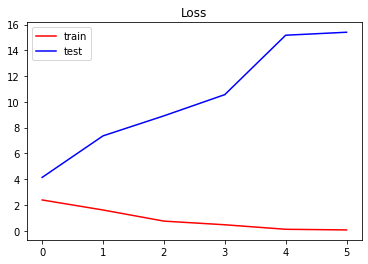

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r',label="train")
plt.plot(hist.history['val_loss'], 'b', label="test")
plt.legend()
plt.show()

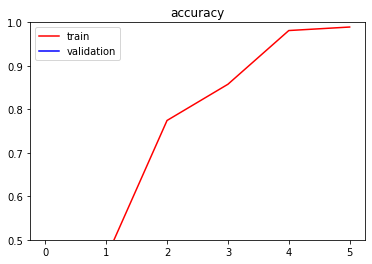

In [ ]:
plt.title('accuracy')
plt.plot(hist.history['accuracy'], 'r', label="train")
plt.plot(hist.history['val_accuracy'], 'b', label="validation")
plt.legend()
plt.ylim([0.5,1])
plt.show()

# result1 = model.predict(test_X)
# print(result1.shape)
# sum = 0
# for i in range(len(result1)):
#   if np.argmax(result1[i]) == np.argmax(test_y[i]):
#     sum += 1
# print(sum / len(test_y))

# **８.音声断片に対して分類を行う、
# ！！！森田さんこっちにテストのデータセットを生成してください**

In [ ]:
#森田
import os

t01 = []
t02 = []
t03 = []
t04 = []
t05 = []
t06 = []
t07 = []
t08 = []
t09 = []
t10 = []
t11 = []
t12 = []
t13 = []

ts = [t01, t02, t03, t04, t05, t06, t07, t08, t09, t10, t11, t12, t13]

for n in range(13):
    
  for i in os.listdir(SS[n]):
    # CALCULATE NUM
    wav = load_wav_16k_mono(SS[n] + '/' + i)
    # wav = wav[int(len(wav) * 0.7):]
    
    NUM = int(len(wav)*0.3 / (10 * 16000))

    for j in range(NUM):
      ts[n].append(os.path.join(SS[n],i+str(j)))


  ts[n] = tf.data.Dataset.from_tensor_slices(ts[n])


In [ ]:
#森田
# data = tf.data.Dataset()
tis = []
for i in range(13):

  indices = i
  depth = 13    

  tis.append( tf.data.Dataset.zip((ts[i], tf.data.Dataset.from_tensor_slices(([tf.one_hot(indices, depth)]*len(ts[i]))))) )

for i in range(len(tis)-1):
  tis[0] = tis[0].concatenate(tis[i+1])
data = tis[0]
#positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
#negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
#data = positives.concatenate(negatives)

print(len(data))

print(data.as_numpy_iterator().next())

390
(b'/content/drive/MyDrive/audio_processing/intern/AFPID-II/AFPID-Raw/S01/S01_6_footstep_audio.wav0', array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))


In [ ]:
def preprocess(file_path, label):
    num = ""
    for i in reversed(file_path):
      if 48<=i<=57:
        num = chr(i) + num
      else:
        break
    wav = load_wav_16k_mono(file_path[:-len(num)])

    num = int(num)
    print(num)
      
    num = int(file_path[-1])

    # wav = wav[:48000]
    # zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    # wav = tf.concat([zero_padding, wav],0)

    #### 

    wav_clip = wav[len(wav) * 0.7 12000*num:12000+12000*num]
    spectrogram = tf.signal.stft(wav_clip, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

# **モデルの導出**

# **予備**

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
yhat = model.predict(X_test)

## 8.2 Convert Logits to Classes 

In [ ]:
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

# 9. Build Forest Parsing Functions

## 9.1 Load up MP3s

In [ ]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
mp3 = os.path.join('/content/drive/MyDrive/audio_processing/audioClassification/data', 'Forest Recordings', 'recording_00.mp3')

In [ ]:
wav = load_mp3_16k_mono(mp3)

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

## 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [ ]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 9.3 Convert Longer Clips into Windows and Make Predictions

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

## 9.4 Group Consecutive Detections

In [ ]:
from itertools import groupby

In [ ]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [ ]:
calls

# 10. Make Predictions

## 10.1 Loop over all recordings and make predictions

In [ ]:
results = {}
for file in os.listdir(os.path.join('/content/drive/MyDrive/audio_processing/audioClassification/data', 'Forest Recordings')):
    FILEPATH = os.path.join('/content/drive/MyDrive/audio_processing/audioClassification/data','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

In [ ]:
results

## 10.2 Convert Predictions into Classes

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

## 10.3 Group Consecutive Detections

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

# 11. Export Results

In [ ]:
import csv

In [ ]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])

劉　問題コード


## 5.1 Build Preprocessing Function

In [ ]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    # audio_slices = 
    # audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=11200, sequence_stride=11200, batch_size=1)
    result_list = []
    wav_list = [wav[12000*i:12000+12000*i] for i in range(4)]
    for wav_single in wav_list:
      spectrogram = tf.signal.stft(wav_single, frame_length=320, frame_step=32)
      spectrogram = tf.abs(spectrogram)
      spectrogram = tf.expand_dims(spectrogram, axis=2)
      result_list.append([spectrogram, label])
    return result_list

## 6.1 Create a Tensorflow Data Pipeline

In [ ]:
data = data.map(preprocess)
data = data.flat_map(tf.data.Dataset.from_tensor_slices)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)
print(len(data))


In [ ]:
import pickle
def save_model(model):
  # モデルの保存
  filename = 'finalized_model.sav'
  pickle.dump(model, open(filename, 'wb'))

def load_model(filename):
  # モデルを読み込み
  loaded_model = pickle.load(open(filename, 'rb'))
  return loaded_model